# SHO Fitting and Nonlinearity Analysis

Functional fitting and nonlinearity analysis for band-excitation spectroscopic data. In this notebook we can a couple of  problems:

1. Functional fitting (e.g., least squares curve fitting). Here the goal is not only to improve the fitting quality, but also to improve the efficiency of the process. A part of this may also involve improving the 'guess' , i.e., the priors for the functional fitting algorithm.

2. Unsupervised machine learning of BE datasets: this dataset looks at the nonlinear response of BiFeO3, captured as a function of the applied AC voltage excitation through the atomic force micorscope tip. How best can be determine the spectral response and local correlations with the domain structure?



In [ ]:
!pip install sidpy SciFiReaders pyNSID wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=4aec9fcf69738959d6be5190125ca3190a3bccc9490562aa803c16c3406ec67d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
#Download dataset
import wget

wget.download(url=r'https://www.dropbox.com/scl/fi/1k0eynm6l2r4vsi6rfso3/bfo_be_ac_conj.h5?rlkey=yd9y9akbnakaui3z8xk6pgkfw&dl=1', out='nl_file.h5')

'nl_file.h5'

#SHO Fitting

Simple harmonic oscillator fitting is done within sidpy's fitter class. By default this includes features such as parallelization (leveraging the dask array on top of which sidpy is built), as well as a special k-means prior generation scheme described in Cerange et al. MLST (2021).

In [ ]:
import os
import sys

import numpy as np
import time
import h5py

import pyNSID
import matplotlib.pyplot as plt
import numba

import sidpy
#Let's open up a sample dataset and see...

import SciFiReaders as sr
from scipy.optimize import curve_fit

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


# Necessary Functions

Here we define the fitting function and a guess function. In principle the guess function is not strictly required, but in practice it is difficult to obtain decent starting points for functional fits without it (at least for many of the cases discussed here). One method to obtain decent guesses is to simply use neural networks trained on millions of forward simulations, as described in [Borodinov et al.](https://www.nature.com/articles/s41524-019-0148-5)

You can replace this with your own strategy as well.

In [ ]:

#This is our main fitting function
def SHO_fit_flattened(wvec,*p):
    Amp, w_0, Q, phi=p[0],p[1],p[2],p[3]
    func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (wvec ** 2 - 1j * wvec * w_0 / Q - w_0 ** 2)
    return np.hstack([np.real(func),np.imag(func)])

#This function is a 'guess' function - it returns a guess that is used as a prior for the full fit
#You can try other guess functions. Or replace it with a neural network, as in Borodinov et al.
#The point is that it is often important to retrieve a good guess before performing functional fits...
def my_guess_fn(freq_vec,ydata):
    ydata = np.array(ydata)
    amp_guess = np.abs(ydata)[np.argmax(np.abs(ydata))]
    Q_guess = 50
    max_min_ratio = np.max(abs(ydata)) / np.min(abs(ydata))
    phi_guess = np.angle(ydata)[np.argmax(np.abs(ydata))]
    w_guess = freq_vec[np.argmax(np.abs(ydata))]

    #Let's just run some Q values to find the closest one
    Q_values = [5,10,20,50,100,200,500]
    err_vals = []
    for q_val in Q_values:
        p_test = [amp_guess/q_val, w_guess, q_val, phi_guess]
        func_out = SHO_fit_flattened(freq_vec,*p_test)
        complex_output = func_out[:len(func_out)//2] + 1j*func_out[(len(func_out)//2):]
        amp_output = np.abs(complex_output)
        err = np.mean((amp_output - np.abs(ydata))**2)
        err_vals.append(err)
    Q_guess = Q_values[np.argmin(err_vals)]
    p0 = [amp_guess/Q_guess, w_guess, Q_guess, phi_guess]
    return p0


# Load the Data

Here the data is a nonlinearity dataset: it ocnsists of dimensions of (X,Y,Vac,cycle,frequency). For more details on such datasets see [Vasudevan et al. ](https://onlinelibrary.wiley.com/doi/full/10.1002/adfm.201201025?casa_token=8tqRzefXfdQAAAAA%3AAp_LzaBXCtXKgN6CwuX2rDDqetA_1pUf4P_OGtUFn27PX0fh8H-w8f2ozDq58_glIWPKd6dmxT8AUqeNoA) This data needs to be fitted to the simple harmonic oscillator model for further analysis. First, let's load the data and then plot some individual pixels to see what it looks like.

In [ ]:
#Let's load the data with SciFiReaders

reader = sr.NSIDReader('nl_file.h5')
data = reader.read()
dataset = data['Channel_001']

(70, 70, 16, 2, 56)


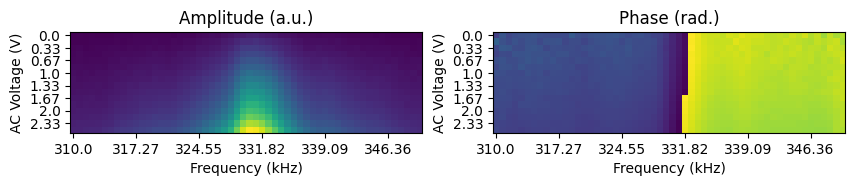

In [ ]:
print(dataset.shape)

#obtain the frequency and voltage axis values
freq_vec = dataset._axes[4].values
voltage_vec = dataset._axes[2].values

#choose a spectrogram - x,y position and cycle number
amp_spectrum = np.abs(dataset[4,10,:,0,:])
phase_spectrum = np.angle(dataset[4,10,:,0,:])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].imshow(amp_spectrum)
axes[0].set_xlabel('Frequency (kHz)')
axes[0].set_ylabel('AC Voltage (V)')
axes[0].set_title('Amplitude (a.u.)')
axes[0].set_yticks(np.arange(0, len(voltage_vec),2));
axes[0].set_yticklabels([np.round(v,2) for v in voltage_vec[::2]]);
axes[0].set_xticks(np.arange(0, len(freq_vec),10));
axes[0].set_xticklabels([np.round(v/1E3,2) for v in freq_vec[::10]]);


axes[1].imshow(phase_spectrum)
axes[1].set_title('Phase (rad.)')
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('AC Voltage (V)')
axes[1].set_yticks(np.arange(0, len(voltage_vec),2));
axes[1].set_yticklabels([np.round(v,2) for v in voltage_vec[::2]]);
axes[1].set_xticks(np.arange(0, len(freq_vec),10));
axes[1].set_xticklabels([np.round(v/1E3,2) for v in freq_vec[::10]]);

In [ ]:
# Let's try sidpy fitter
#Instantiate the SidFitter class
fitter = sidpy.proc.fitter.SidFitter(dataset, SHO_fit_flattened,num_workers=4,guess_fn = my_guess_fn,ind_dims=[0,1,2,3],
                           threads=1, return_cov=False, return_fit=False, return_std=False,
                           km_guess=True,num_fit_parms = 4, n_clus = 5)

#Note that without bounds, the fitting is not very good
lb = [0.0, 310.0E3, 5, -2*np.pi]
ub = [0.1, 380.0E3, 500, 2*np.pi]

fit_parameters = fitter.do_fit(bounds = (lb,ub))

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:44607
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38157'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42047'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42539'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42191'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36629 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36629
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:56228
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:42141 name: 0
INFO:

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 66.99 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


---Finished KMeans, onto fiting each KM Center---
Fitting center 0
Fitting center 1
Fitting center 2
Fitting center 3
Fitting center 4


/usr/local/lib/python3.10/dist-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 116.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
INFO:distributed.core:Event loop was unresponsive in Scheduler for 11.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 11.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 11.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause time

# Plot Fit Results

Plot a selection of the data - the raw data alongside the fit, to see how good these fits are....

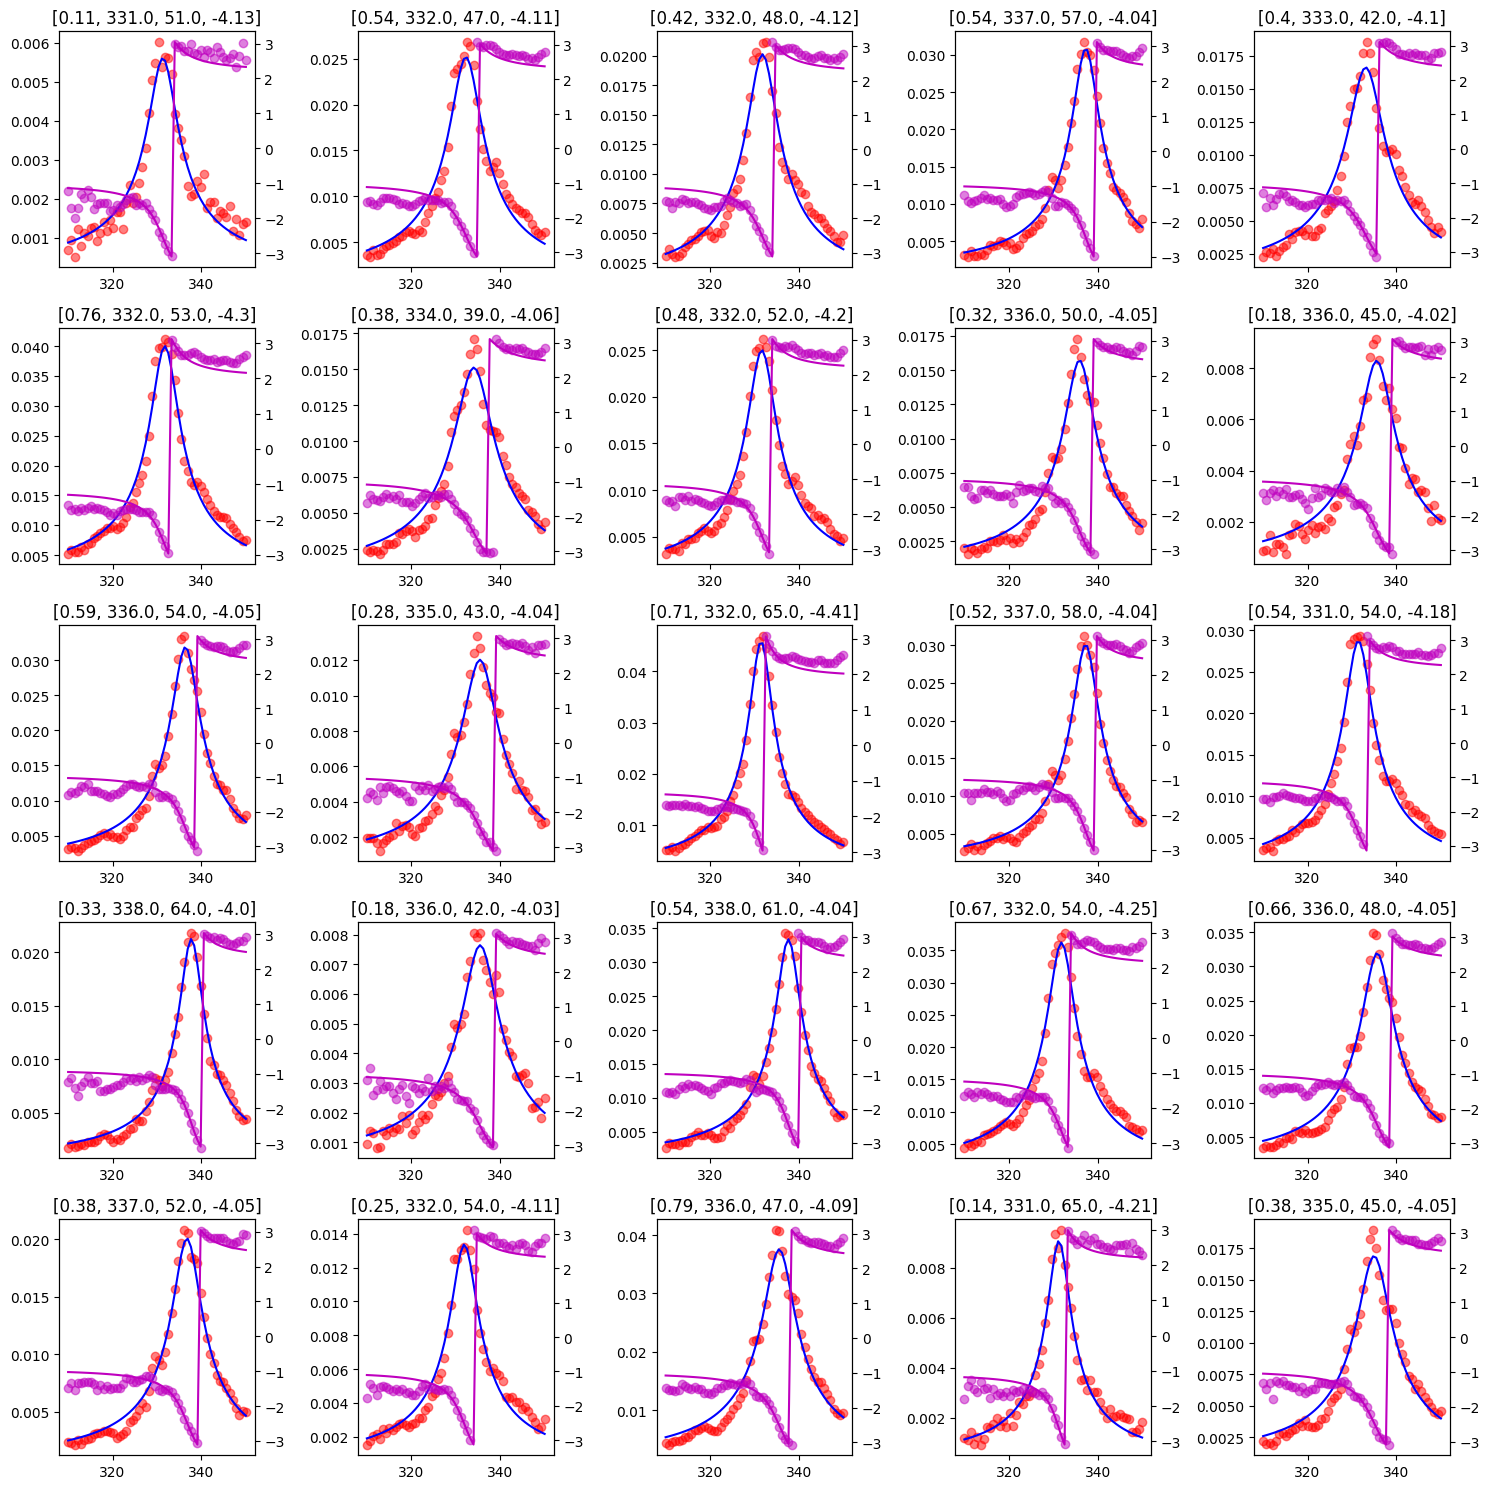

In [40]:
fit_parameters_mat = np.array(fit_parameters[0])

fig, axes = plt.subplots(nrows=5, ncols=5, figsize = (15,15))
for ind, ax in enumerate(axes.flat):
    ind_plot = [np.random.randint(low=0, high = dataset.shape[0]),np.random.randint(low=0, high = dataset.shape[1]),
                np.random.randint(low=0, high = dataset.shape[2]),np.random.randint(low=0, high = dataset.shape[3])]

    ydata = np.array(dataset[ind_plot[0], ind_plot[1], ind_plot[2], ind_plot[3],:])
    fit_parms = fit_parameters_mat[ind_plot[0], ind_plot[1], ind_plot[2], ind_plot[3], :]

    ydata_fit = SHO_fit_flattened(freq_vec, *fit_parms)
    complex_output = ydata_fit[:len(ydata_fit)//2] + 1j*ydata_fit[(len(ydata_fit)//2):]
    amp_fit = np.abs(complex_output)
    phase_fit = np.angle(complex_output)

    ax.plot(freq_vec/1E3, np.abs(ydata), 'ro', alpha = 0.5)
    ax.plot(freq_vec/1E3, amp_fit, 'b-')
    fit_parms_labels = [np.round(fit_parms[0]*1E3,2), np.round(fit_parms[1]/1E3 , 0), np.round(fit_parms[2],0), np.round(fit_parms[3],2)]
    ax.set_title(str(fit_parms_labels))
    ax2 = plt.twinx(ax=ax)
    ax2.plot(freq_vec/1E3, np.angle(ydata), 'mo', alpha = 0.5)
    ax2.plot(freq_vec/1E3, phase_fit, 'm-')

fig.tight_layout()

# Code challenge:

Can you do better than these fits? One of the major methods to improve fits is to start with better priors. Other challenges include speeding them up (e.g., can you use GPUs parallelization?).

# Nonlinearity analysis

The fitted dataset can be further analyzed for nonlinearity as a function of V<sub>AC</sub>. This is easily done via polynomial fitting. Are there other ways to analyze this data that you can come up with?

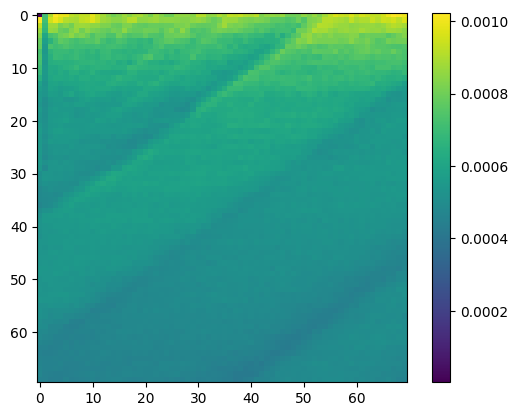

In [43]:
fit_parameters_np = np.array(fit_parameters[0])
fit_parameters_np.shape

plt.figure()
plt.imshow(fit_parameters_np[:,:,10,0,0])
plt.colorbar()

#do some polynomial fits
poly_fits = []
for xval in range(fit_parameters_np.shape[0]):
  for yval in range(fit_parameters_np.shape[1]):
    ydata = fit_parameters_np[xval,yval,:,0,0]
    poly_fits.append(np.polyfit(voltage_vec,ydata,2))
poly_fits = np.array(poly_fits)


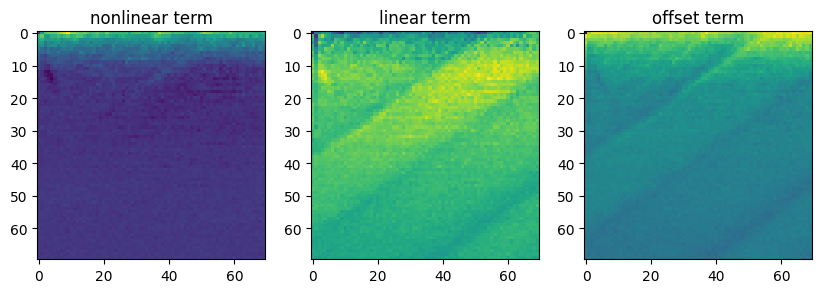

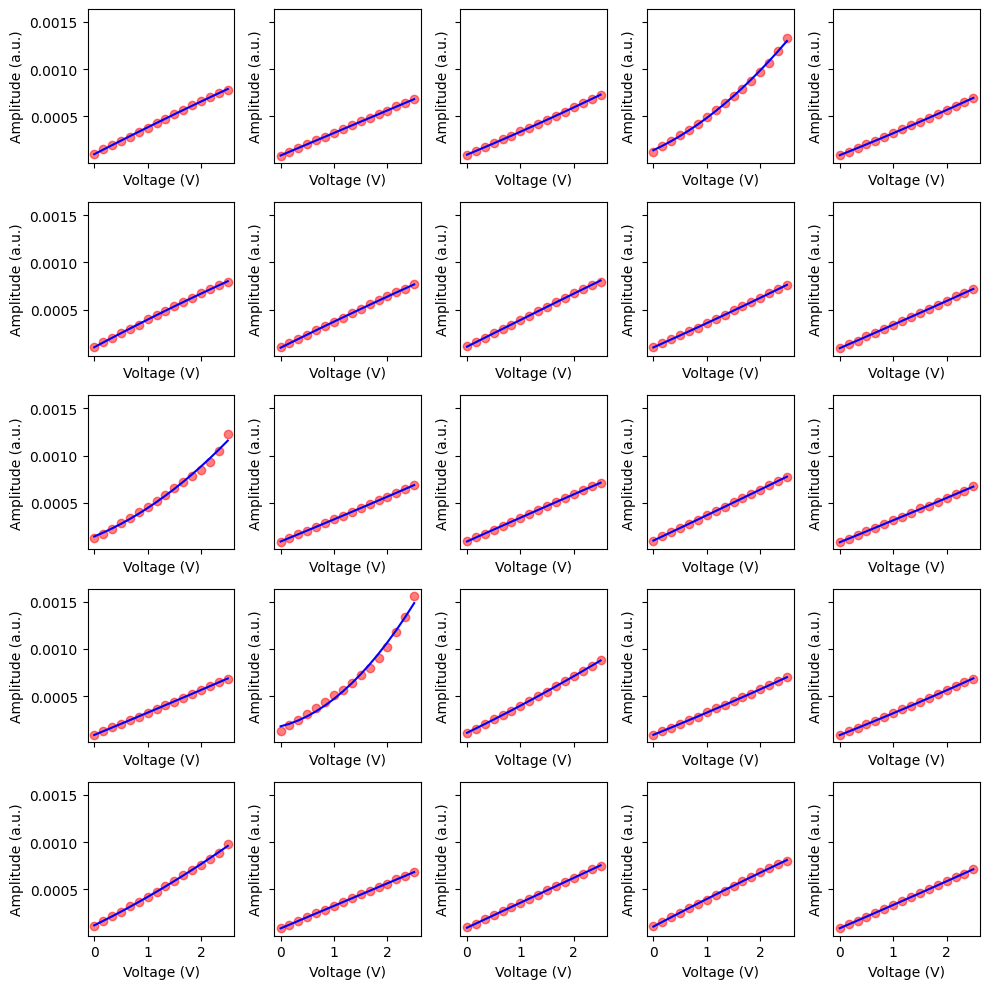

In [50]:
poly_fits = np.reshape(poly_fits, (fit_parameters_np.shape[0], fit_parameters_np.shape[1], 3))
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(10,3))
axes[0].imshow(poly_fits[:,:,0])
axes[0].set_title('nonlinear term')
axes[1].imshow(poly_fits[:,:,1])
axes[1].set_title('linear term')
axes[2].imshow(poly_fits[:,:,2])
axes[2].set_title('offset term')

#Plot some individual fits
fig, axes = plt.subplots(nrows=5,ncols=5, figsize=(10,10), sharex=True, sharey=True)
for ind, ax in enumerate(axes.flat):
  ind_plot = [np.random.randint(low=0, high = fit_parameters_np.shape[0]),
              np.random.randint(low=0, high = fit_parameters_np.shape[1])]
  ydata = fit_parameters_np[ind_plot[0], ind_plot[1],:,0,0]
  ax.plot(voltage_vec, ydata, 'ro', alpha = 0.5)
  ax.plot(voltage_vec, np.polyval(poly_fits[ind_plot[0], ind_plot[1],:], voltage_vec), 'b-')
  ax.set_xlabel('Voltage (V)')
  ax.set_ylabel('Amplitude (a.u.)')
fig.tight_layout()

Think about the nonlinear term - the nonlinearity may be better expressed as a ratio of the nonlinear term over the linear term. Other unsupervised methods to analyze this data may also be useful.